### 0.0. IMPORTS

In [2]:
# instalando bibliotecas
# !pip install pandas
# !pip install inflection
# !pip install math
# !pip install seaborn
# !pip install matplotlib
# !pip install datetime
# !pip install scikit-learn;

In [3]:
import math
import numpy   as np
import pandas  as pd
import inflection 

import seaborn as sns

from scipy                  import stats as ss
from matplotlib             import pyplot as plt
from IPython.display        import Image
from IPython.core.display   import HTML
import datetime

from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder


##### 0.1 Helper Functions 

In [4]:
# Função que calcula o V de Cramer
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chir2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chir2corr/n)/(min(kcorr-1,rcorr-1)))
    
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    sns.set_palette("Reds") 
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [5]:
jupyter_settings()

##### 0.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


### 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

##### 1.1. Rename Columns

In [8]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
#função que irá formatar as palavras da coluna do dataframe. Eles ficaram todos com letra minusculas e separadas por _
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

In [10]:
df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

##### 1.2. Data Dimensions

In [12]:
print('N° total de linhas: ', df1.shape[0])
print('N° total de colunas: ', df1.shape[1])

N° total de linhas:  1017209
N° total de colunas:  18


##### 1.3 Data Types

In [13]:
# Verificação do tipo de dados
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
#Convertendo a coluna date de object para datetime
df1.date = pd.to_datetime(df1.date)

In [15]:
#Verificando novamente
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

##### 1.5. Fillout NA

In [16]:
#Verificando os valores vazios
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [17]:
#competition_distance: 2642
#Metodo: Substituir por um valor muito alto, deixando de ser um competidor próximo
#df1.competition_distance.max()
df1.competition_distance = df1.competition_distance.apply(lambda x:200000.0 if math.isnan(x) else x)

#competition_open_since_month: 323348
#Metodo: vai ser o valor de mes da coluna Date
df1.competition_open_since_month = df1.apply(lambda x:x.date.month if math.isnan(x.competition_open_since_month) else x.competition_open_since_month, axis=1)

#competition_open_since_year: 323348
#Metodo: vai ser o valor de ano da coluna Date
df1.competition_open_since_year = df1.apply(lambda x:x.date.year if math.isnan(x.competition_open_since_year) else x.competition_open_since_year,axis=1)

#promo2_since_week: 508031
#Metodo: vai ser o valor de semana da coluna Date
df1.promo2_since_week = df1.apply(lambda x:x.date.week if math.isnan(x.promo2_since_week) else x.promo2_since_week, axis=1)

#promo2_since_year: 508031
#Metodo: vai ser o valor do ano da coluna Date
df1.promo2_since_year = df1.apply(lambda x:x.date.year if math.isnan(x.promo2_since_year) else x.promo2_since_year, axis=1)

#promo_interval: 508031
#Metodo: 1. criar um dicionario dos meses do ano, 2.preencher os vazios com valor 0, 3. , 4. 
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}

df1.promo_interval.fillna(0, inplace=True)

df1['month_map'] = df1.date.dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [18]:
df1.sample(5).T

,71266,451896,133083,107497,1015169
store,1022,1107,399,458,190
day_of_week,5,5,5,7,3
date,2015-05-29 00:00:00,2014-05-23 00:00:00,2015-04-03 00:00:00,2015-04-26 00:00:00,2013-01-02 00:00:00
sales,7808,6239,0,0,6927
customers,857,689,0,0,654
open,1,1,0,0,1
promo,0,1,1,0,0
state_holiday,0,0,b,0,0
school_holiday,0,0,1,0,1
store_type,a,a,a,c,a


##### 1.6. Change Types

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1.competition_open_since_month = df1.competition_open_since_month.astype('int64')
df1.competition_open_since_year = df1.competition_open_since_year.astype('int64')

df1.promo2_since_week = df1.promo2_since_week.astype('int64')
df1.promo2_since_year = df1.promo2_since_year.astype('int64')

In [21]:
#As vezes por limitação de memoria, quando roda o codigo ".astype(int)", o que era pra ser int64 fica como int32, verifique:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

##### 1.7. Descriptive Statistical

In [22]:
# 1° passo - Separar em dados com variaveis numericas e categoricas
num_atributtes = df1.select_dtypes(include=['int64','float64'])
cat_atributtes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

##### 1.7.1. Numerical Atributtes

In [23]:
#Uma analise estatistica das variaveis numericas segue analisar: minimo,maximo,range,media,mediana,std,skew,curtosis

#Central Tendency = mean, median 
ct1 = pd.DataFrame(num_atributtes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributtes.apply(np.median)).T

# Dispersion = std, min,max,range(amplitude),skew e kurtosis
d1 = pd.DataFrame(num_atributtes.apply(np.std)).T
d2 = pd.DataFrame(num_atributtes.apply(min)).T
d3 = pd.DataFrame(num_atributtes.apply(max)).T
d4 = pd.DataFrame(num_atributtes.apply(lambda x:x.max()- x.min())).T
d5 = pd.DataFrame(num_atributtes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_atributtes.apply(lambda x:x.kurtosis())).T

# Concatenar 
metricas = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

#Renomear colunas
metricas.columns = ['atributtes','min','max','range','mean','median','std','skew','kurtosis']

metricas               

,atributtes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Rodrigo Cruz\AppData\Local\Temp\ipykernel_6564\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

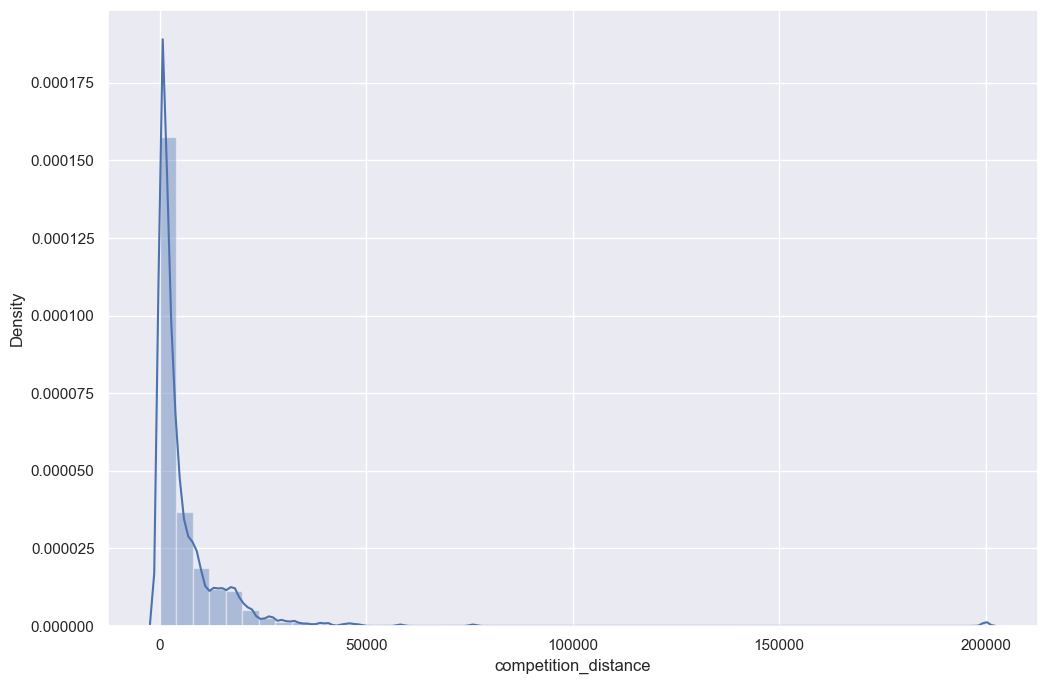

In [24]:
sns.distplot(df1['competition_distance'])

##### 1.7.2. Categorical Atributtes

In [25]:
# metodo que ve os valores unicos de cada uma das categorias
cat_atributtes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='state_holiday', ylabel='sales'>

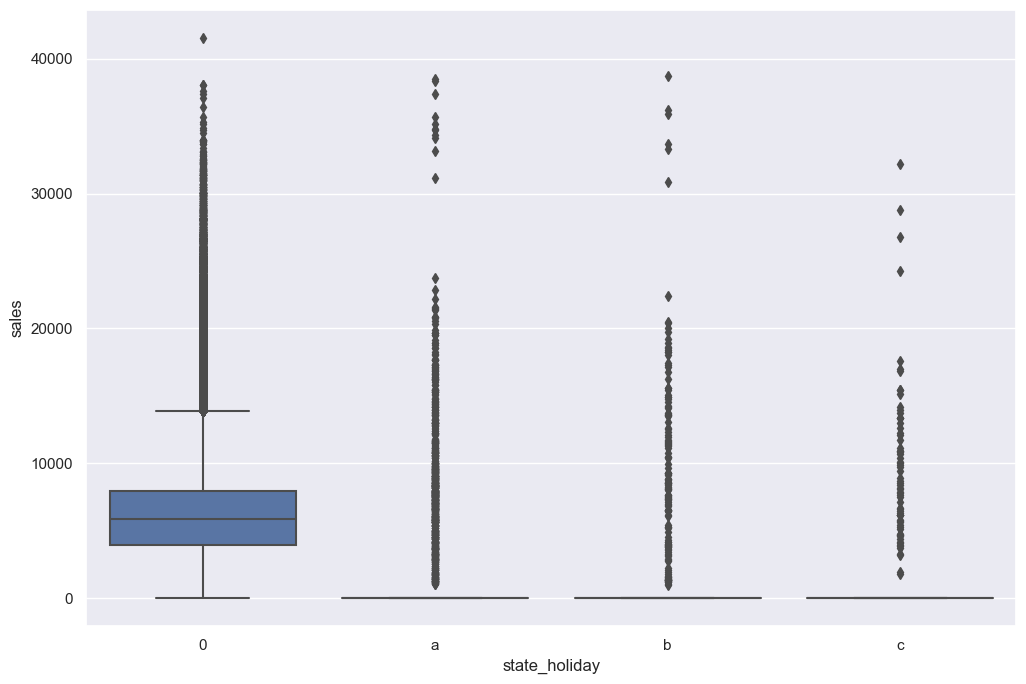

In [26]:
# Boxplot para analisar as variaveis categoricas
sns.boxplot(x='state_holiday',y='sales',data=df1)

<Axes: xlabel='assortment', ylabel='sales'>

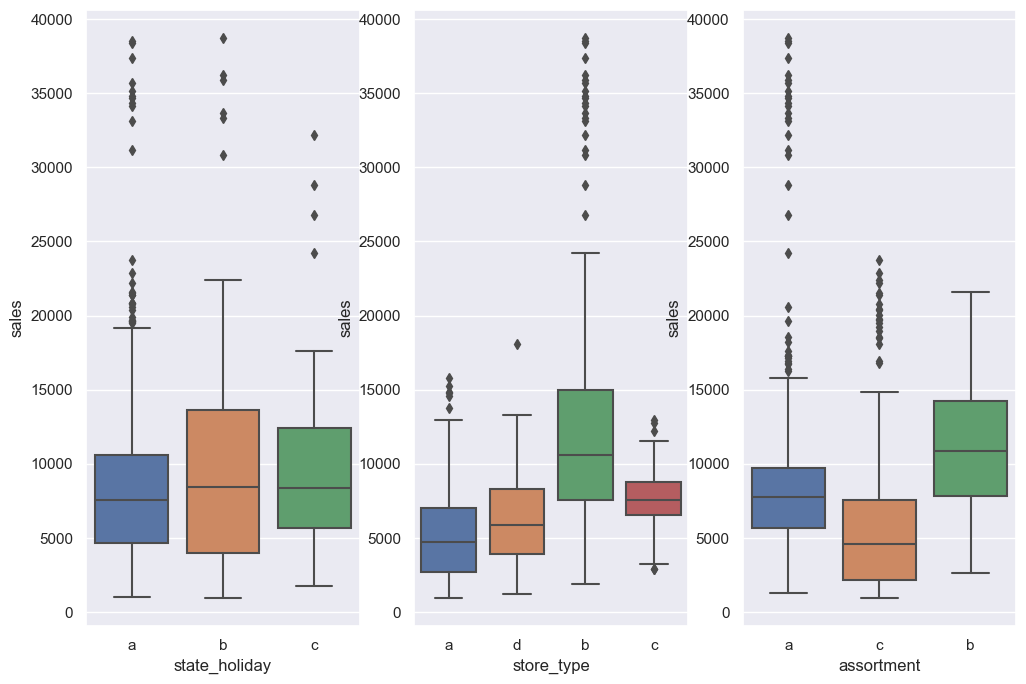

In [27]:
# Para melhora a visualização, foi removido dos dias quando as lojas estavam fechadas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

### 2.0 FEATURES ENGINEERING

In [28]:
df2 = df1.copy()

##### 2.1. Mapa Mental de Hipoteses

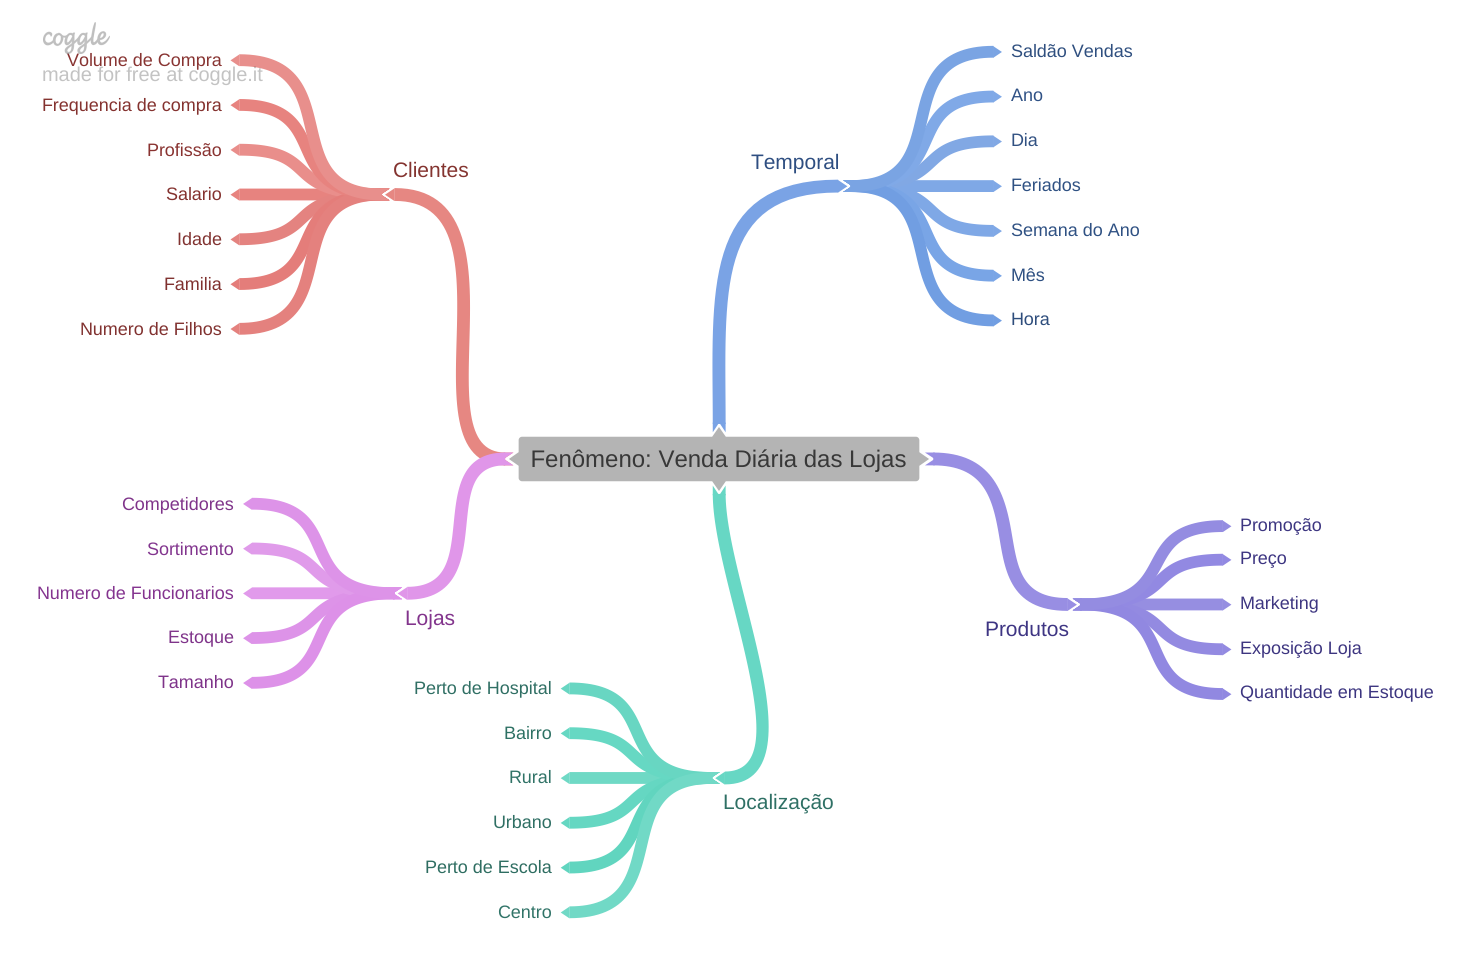

In [29]:
Image('img\Mindmap_Hipoteses.png')

##### 2.2. Criação de Hipoteses

2.2.1. Hipoteses Loja 

**1.** Loja com maior quadro de funcionarios DEVERIAM vender mais.

**2.** Loja com maior estoque DEVERIAM vender mais.

**3.** Loja com menor porte (tamanho) DEVERIAM vender menos.

**4.** Lojas com maior sortimento DEVERIAM vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais

2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em marketing DEVERIAM vender mais

**2.** Lojas que expoem mais os produtos da vitrine DEVERIAM vender mais

**3.** Lojas que tem preços menores por mais tempo DEVERIAM vender mais

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

2.2.3. Hipoteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

##### 2.3. Lista Final das Hipóteses  

- Priorizar as hipoteses para usar na seção de analise exploratoria de dados
- Para priorizar, separar as hipoteses com os dados que já tem disponivel na dataset

Hipoteses de Lojas
- **1.** Lojas com maior sortimento DEVERIAM vender mais.
- **2.** Lojas com competidores mais próximos deveriam vender menos.
- **3.** Lojas com competidores à mais tempo deveriam vender mais.

Hipoteses de Produtos
- **4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
- **5.** Lojas com mais dias de promoção deveriam vender mais.
- **6.** Lojas com mais promoções consecutivas deveriam vender mais.

Hipoteses Temporal
- **7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
- **8.** Lojas deveriam vender mais ao longo dos anos
- **9.** Lojas deveriam vender mais no segundo semestre do ano
- **10.** Lojas deveriam vender mais depois do dia 10 de cada mês
- **11.** Lojas deveriam vender menos aos finais de semana
- **12.** Lojas deveriam vender menos durante os feriados escolares

##### 2.4. Feature Engineering

In [30]:
# Derivar as variáveis das colunas

# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


### 3.0 FILTRAGEM DE VARIAVEIS 

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Aug,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Aug,0,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Aug,0,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Aug,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Aug,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


##### 3.1. Filtragem das Linhas

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

##### 3.2. Seleção de Colunas

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

### 4.0 ANALISE EXPLORATÓRIA DOS DADOS (EDA)

**Motivação:** Como as variaveis impactam a variavel resposta e quantificar esse impacto

In [35]:
df4 = df3.copy()

#### 4.1. Analise Univariada

##### 4.1.1 Response Variables

C:\Users\Rodrigo Cruz\AppData\Local\Temp\ipykernel_6564\1473926699.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])


<Axes: xlabel='sales', ylabel='Density'>

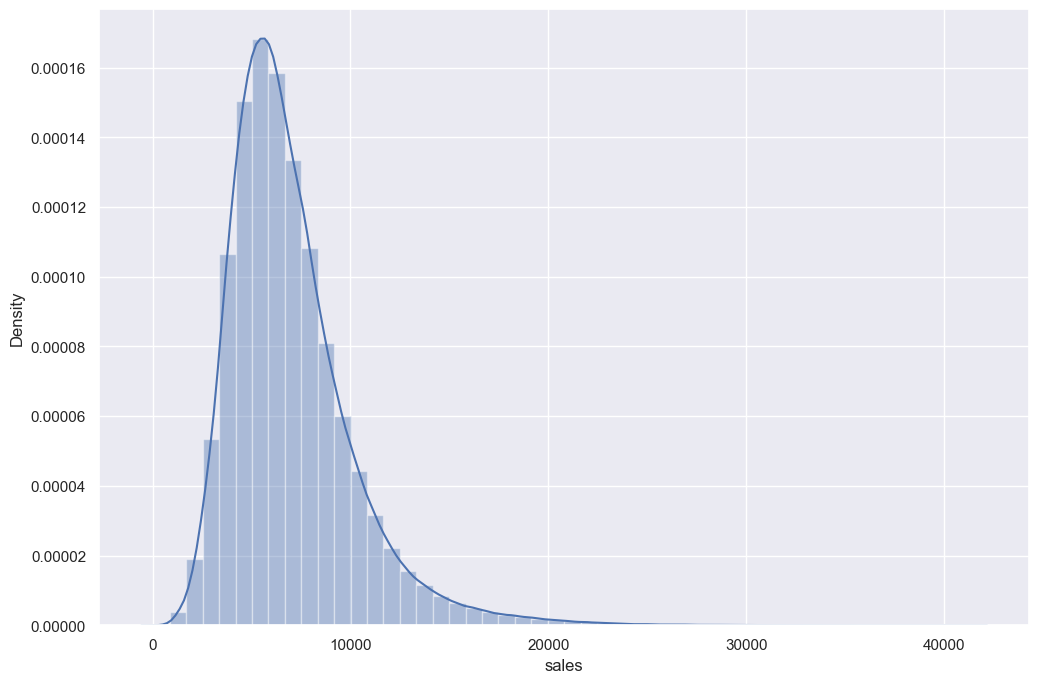

In [36]:
sns.distplot(df4['sales'])

##### 4.1.2 Numerical Variables

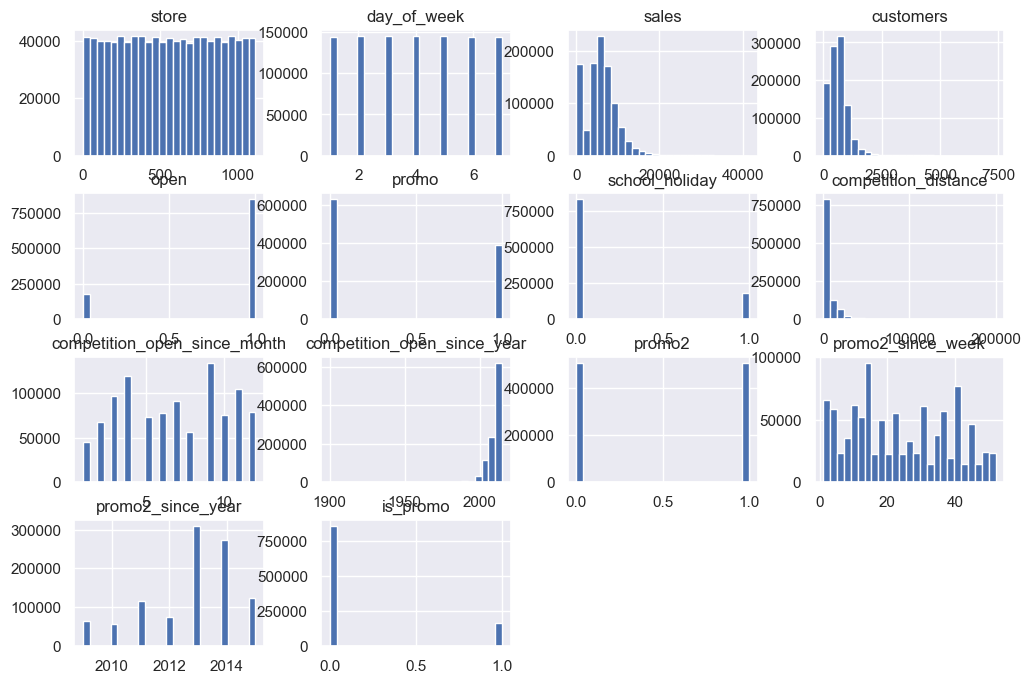

In [37]:
num_atributtes.hist(bins=25);

##### 4.1.3 Categorical Variables

In [38]:
print('state_holiday \n',df4.state_holiday.drop_duplicates())
print('store_type \n',df4.store_type.drop_duplicates())
print('assortment\n',df4.assortment.drop_duplicates())

state_holiday 
 0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object
store_type 
 0     c
1     a
12    d
84    b
Name: store_type, dtype: object
assortment
 0         basic
3      extended
258       extra
Name: assortment, dtype: object


<Figure size 1500x1600 with 0 Axes>

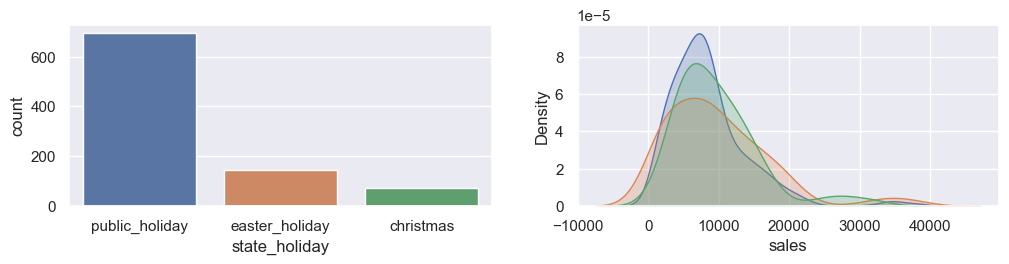

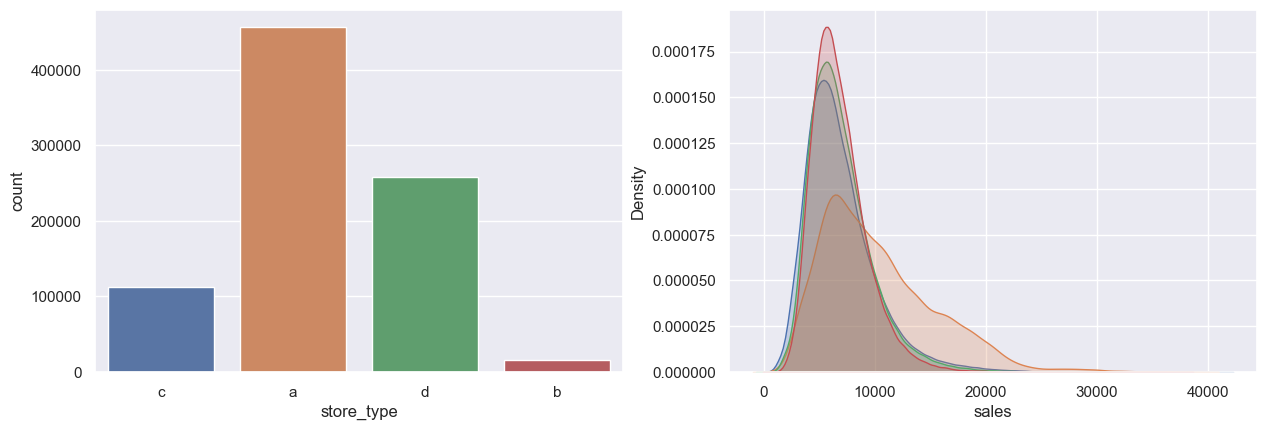

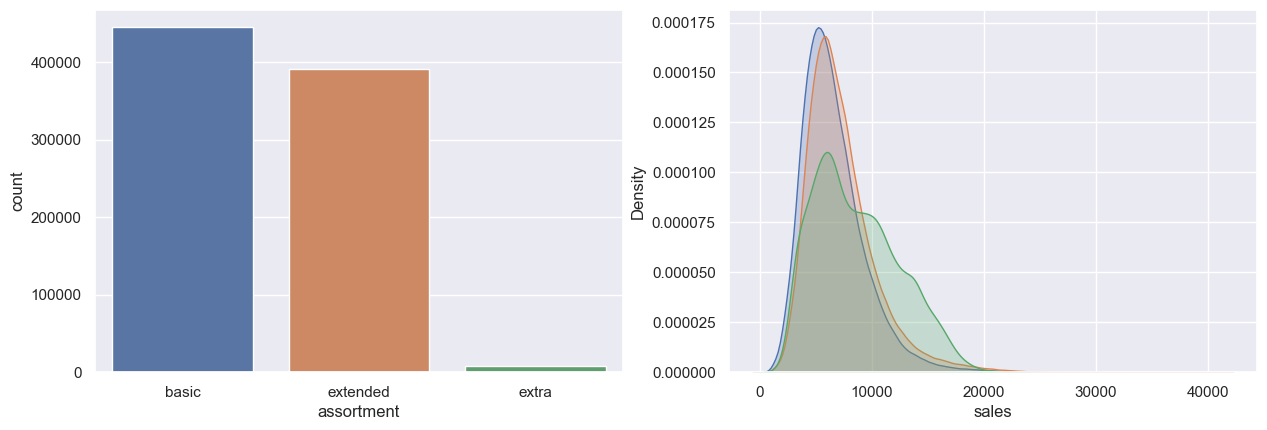

<Figure size 1500x1600 with 0 Axes>

In [39]:
# state holiday
plt.subplot(3,2,1)
a = df4[df4.state_holiday != 'regular_day']
sns.countplot(data=a, x=a.state_holiday)


plt.subplot(3,2,2)
sns.kdeplot(df4[df4.state_holiday == 'public_holiday']['sales'], label='public_holiday',fill=True)
sns.kdeplot(df4[df4.state_holiday == 'easter_holiday']['sales'], label='easter_holiday',fill=True)
sns.kdeplot(df4[df4.state_holiday == 'christmas']['sales'], label='christmas',fill=True)

plt.figure(figsize=(15,16))

#store_type
plt.subplot(3,2,3)
sns.countplot(data=df4, x=df4.store_type)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4.store_type == 'a']['sales'], label='a',fill=True)
sns.kdeplot(df4[df4.store_type == 'b']['sales'], label='b',fill=True)
sns.kdeplot(df4[df4.store_type == 'c']['sales'], label='c',fill=True)
sns.kdeplot(df4[df4.store_type == 'd']['sales'], label='d',fill=True)


plt.figure(figsize=(15,16))
#assortment
plt.subplot(3,2,5)
sns.countplot(data=df4, x=df4.assortment)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4.assortment == 'basic']['sales'], label='basic',fill=True)
sns.kdeplot(df4[df4.assortment == 'extended']['sales'], label='extended',fill=True)
sns.kdeplot(df4[df4.assortment == 'extra']['sales'], label='extra',fill=True)
plt.figure(figsize=(15,16))



#### 4.2. Analise Bivariada

##### **H1.** Lojas com maior sortimento DEVERIAM vender mais.

<Axes: xlabel='assortment', ylabel='sales'>

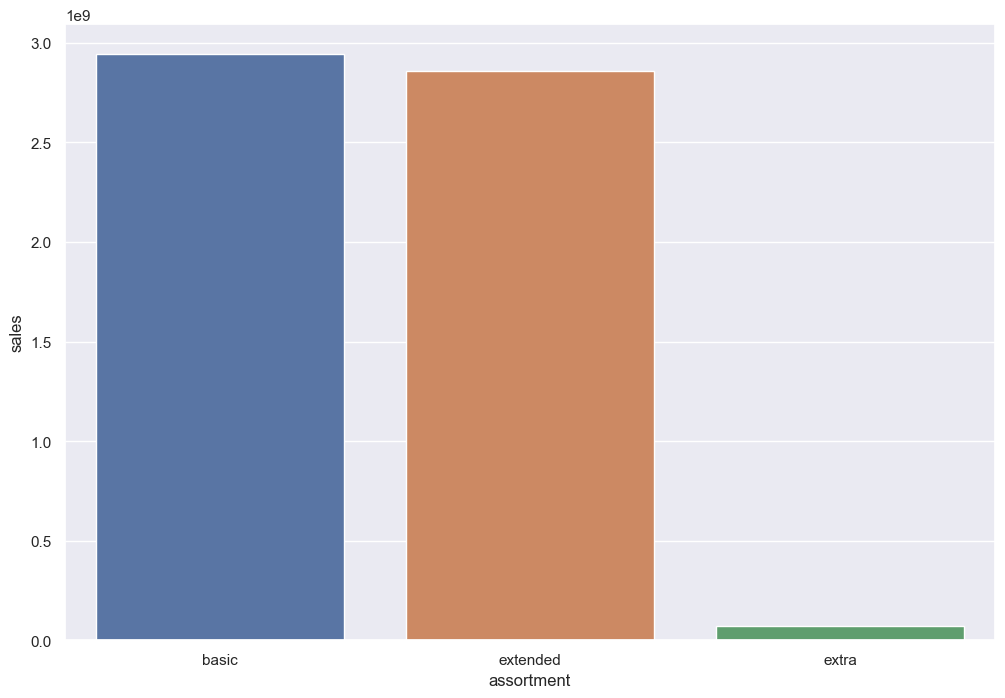

In [40]:
aux1=df4[['assortment','sales']].groupby('assortment').sum().reset_index()


sns.barplot(x='assortment', y='sales',data=aux1 )

In [41]:
aux2=df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()


aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


<Axes: xlabel='year_week'>

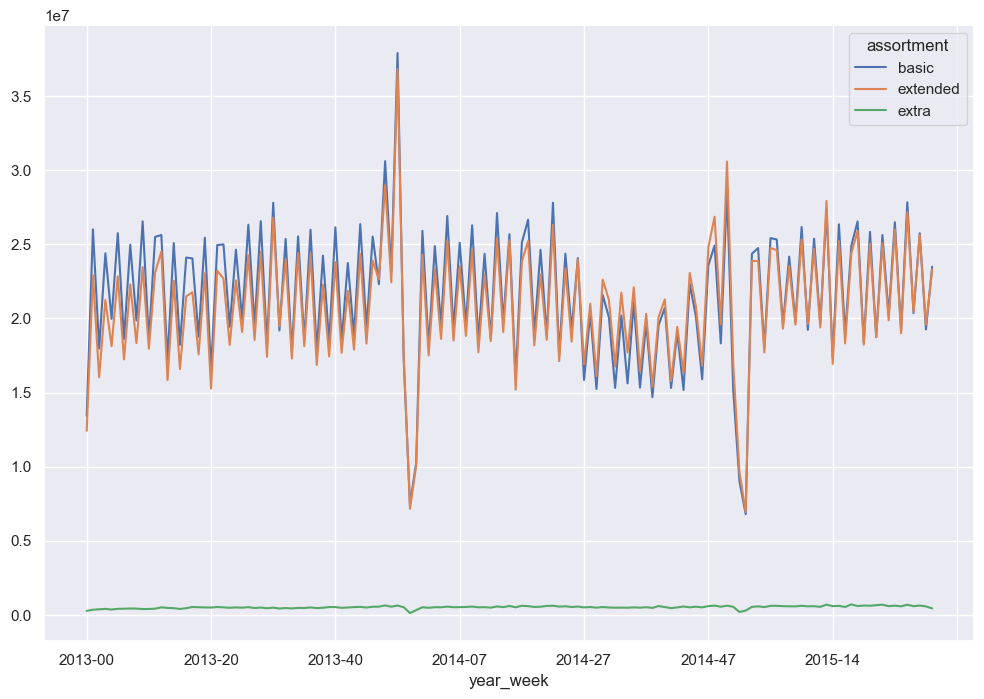

In [42]:
# Fazendo um PIVOT
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

<Axes: xlabel='year_week'>

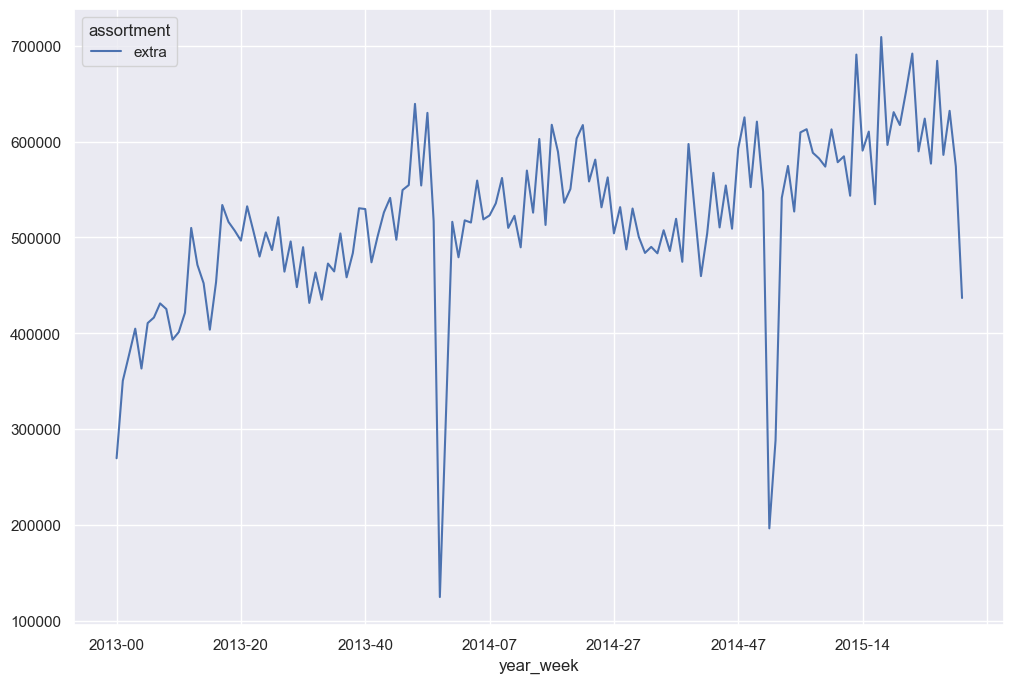

In [43]:
aux3 = aux2[aux2.assortment == 'extra']

aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

As lojas que tem o assortment do tipo basic e extended tem aproximadamento o mesmo volume de vendas. E o extra tem um volume de vendas menor. 

Lojas com maior sortimento deveria vender mais (ERRADO) --> Lojas com maior sortimento vendem menos

A variavel vai ser importante para o modelo pois elas tem uma sazonalidade bem diferente, vai ser boa para o aprendizado do modelo. 

##### **H2.** Lojas com competidores mais próximos deveriam vender menos.


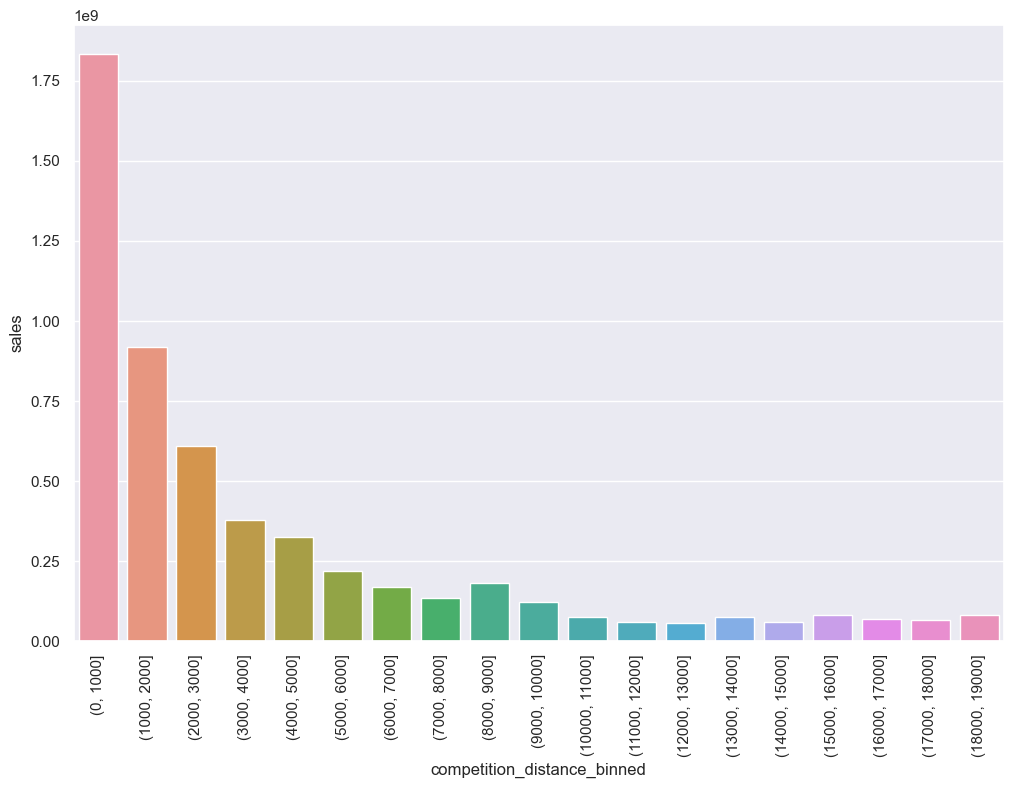

In [44]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins =list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1.competition_distance, bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

_ = sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
_ = plt.xticks(rotation=90)

A partir do grafico, quando os competidores estão mais próximo, vendem mais! Então a hipotese de que loja com competidores mais próximos vendem menos (FALSA)

<Axes: xlabel='competition_distance', ylabel='sales'>

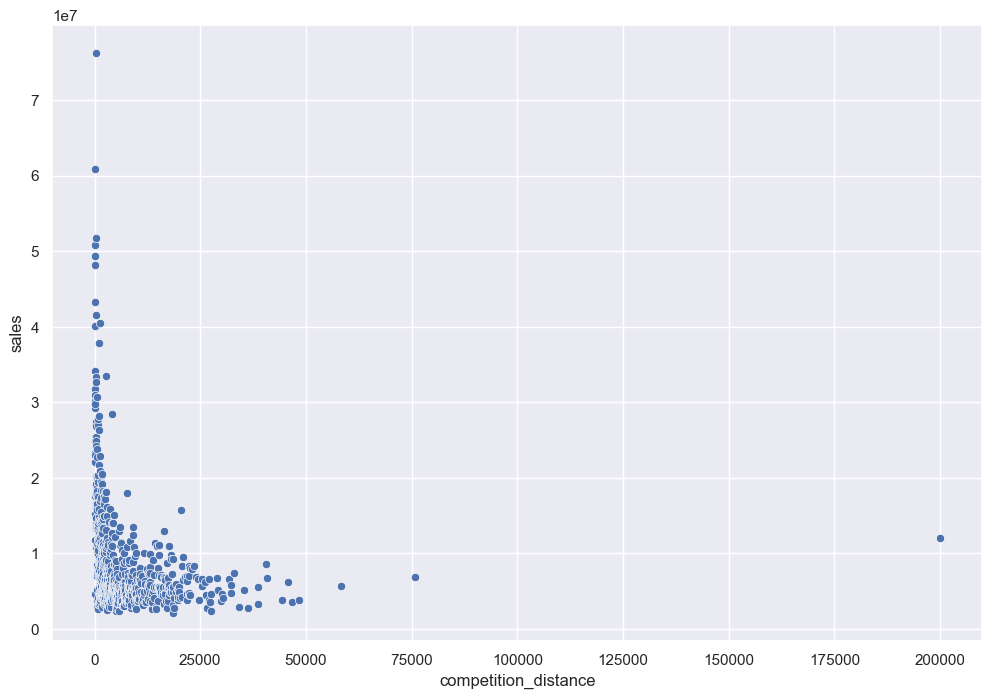

In [45]:
# Outra maneira de visualizar a hipotese
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x='competition_distance', y='sales', data=aux1)

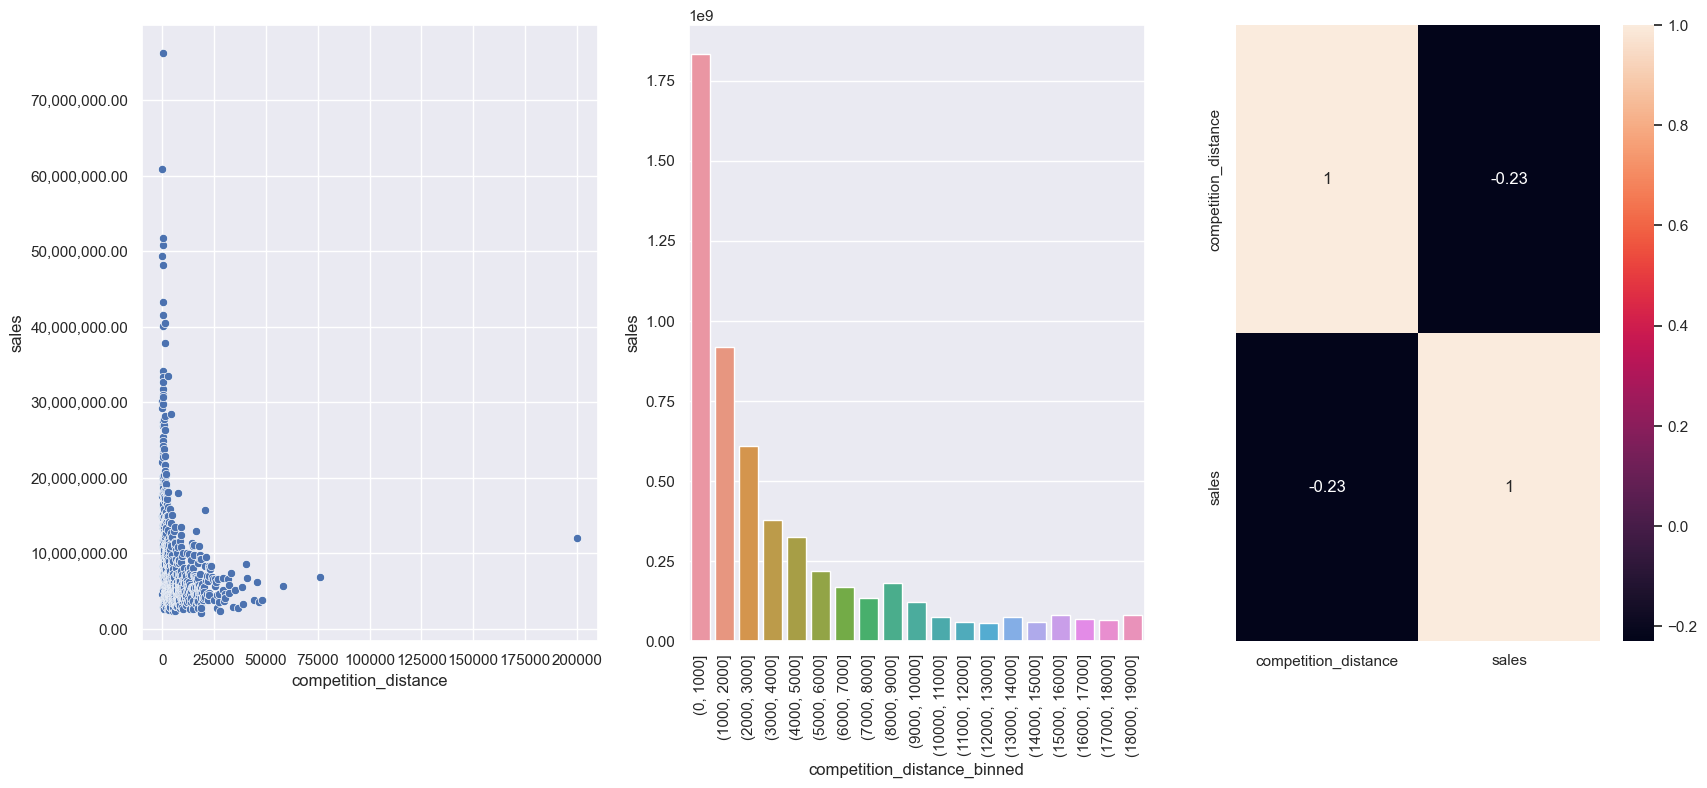

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
a = sns.scatterplot(x='competition_distance', y='sales', data=aux1)
a.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))

plt.subplot(1,3,2)
_ = sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
_ = plt.xticks(rotation=90)
# b.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### **H3.** Lojas com competidores à mais tempo deveriam vender mais.

<Axes: >

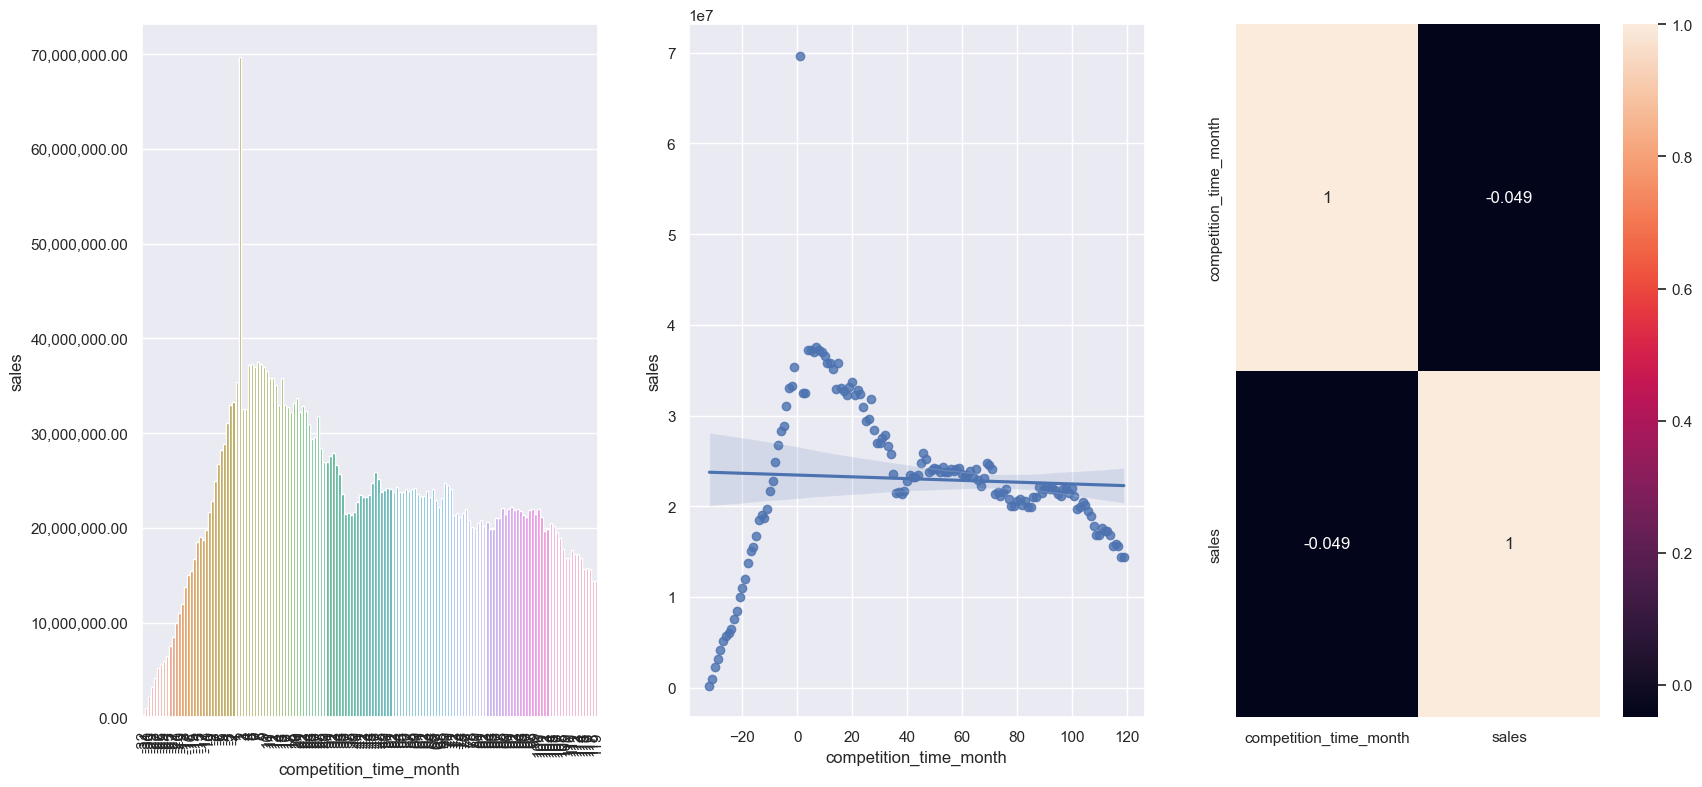

In [47]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
filtro  = aux1[(aux1['competition_time_month']< 120) & (aux1['competition_time_month'] != 0 )]

plt.figure(figsize=(20,9))

plt.subplot(1,3,1)
graf = sns.barplot(x='competition_time_month', y='sales', data=filtro)
graf.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
_= plt.xticks(rotation=90)

plt.subplot(1,3,2)
_=sns.regplot(x='competition_time_month', y='sales', data=filtro)

plt.subplot(1,3,3)
sns.heatmap(filtro.corr(method='pearson'),annot=True)


**Quando mais recente for as competições e abertura das lojas, maior as vendas. Lojas com competidores à mais tempo, VENDEM MENOS!**

##### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

<Axes: >

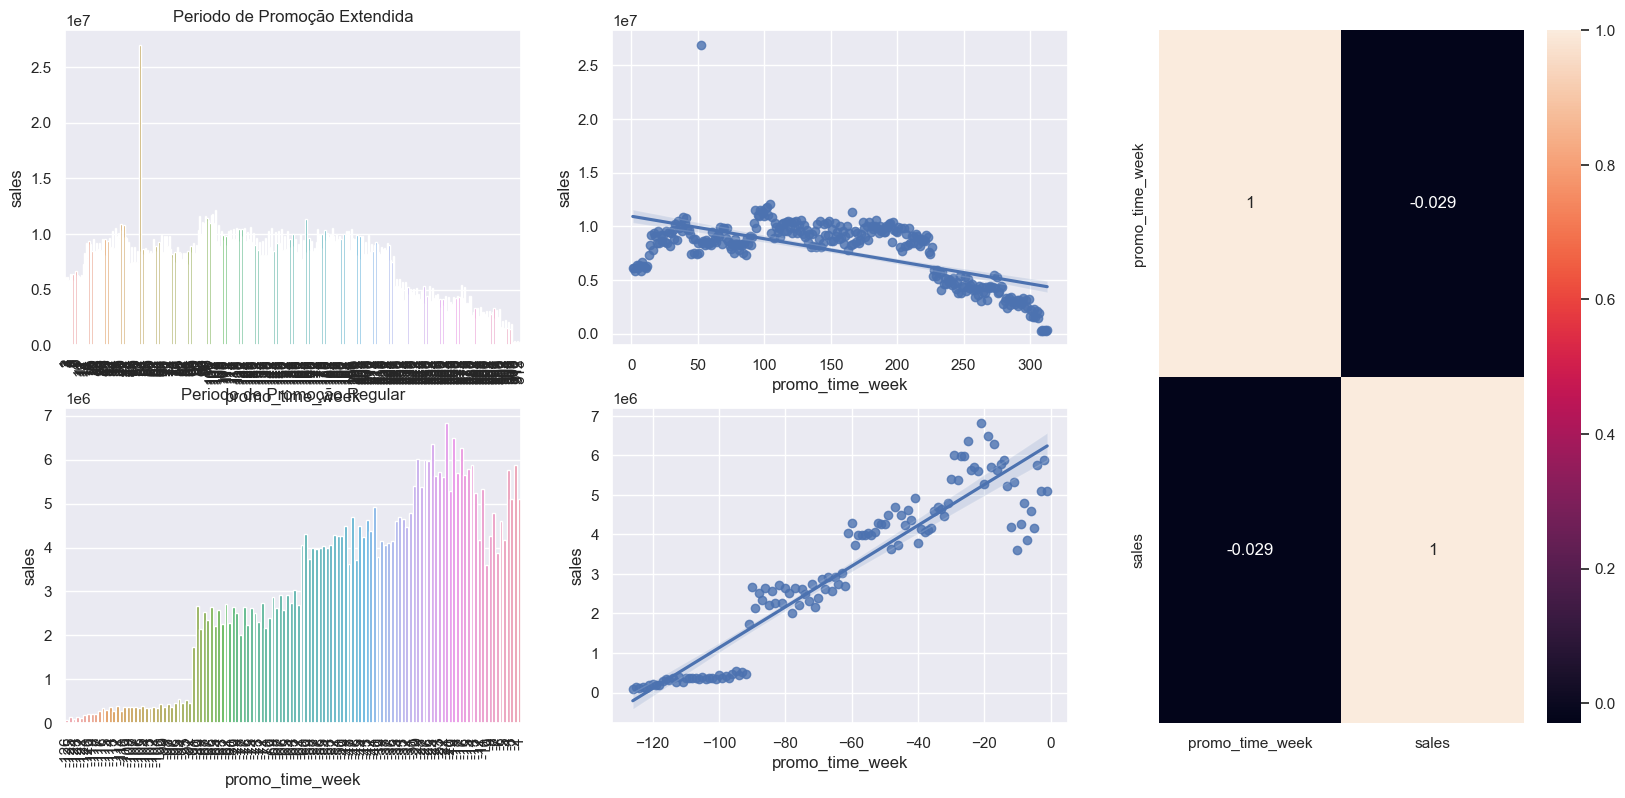

In [48]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
# sns.barplot(x='promo_time_week', y='sales', data=aux1)

from matplotlib.gridspec import GridSpec

grid = GridSpec(2,3)
plt.figure(figsize=(20,9))
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
_ = sns.barplot(x='promo_time_week', y='sales', data=aux2)
_ = plt.xticks(rotation=90)
plt.title('Periodo de Promoção Extendida')

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
_ =sns.barplot(x='promo_time_week', y='sales', data=aux3)
_ = plt.xticks(rotation=90)
plt.title('Periodo de Promoção Regular')

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)


##### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais,\s>

##### **H6.** Lojas com mais promoções consecutivas deveriam vender mais

In [49]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


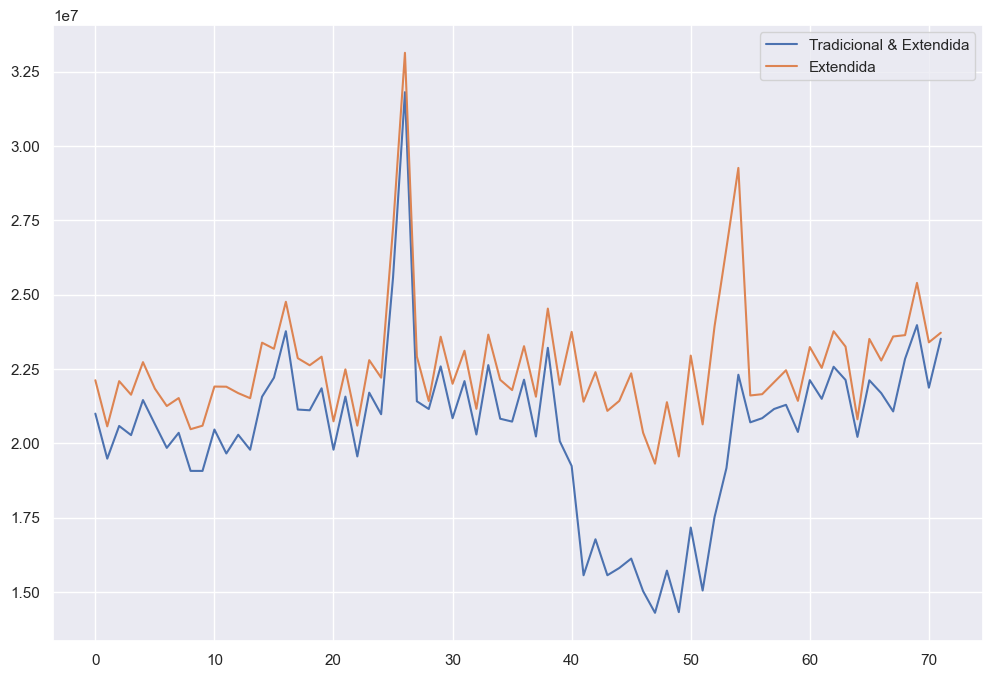

In [50]:
aux = df4[(df4.promo == 1) & (df4.promo2 == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux.plot()

aux1 = df4[(df4.promo == 1) & (df4.promo2 == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux1.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida'])

**Lojas com mais promoção consecutivas deveriam vender mais**

##### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais

<Axes: xlabel='year', ylabel='sales'>

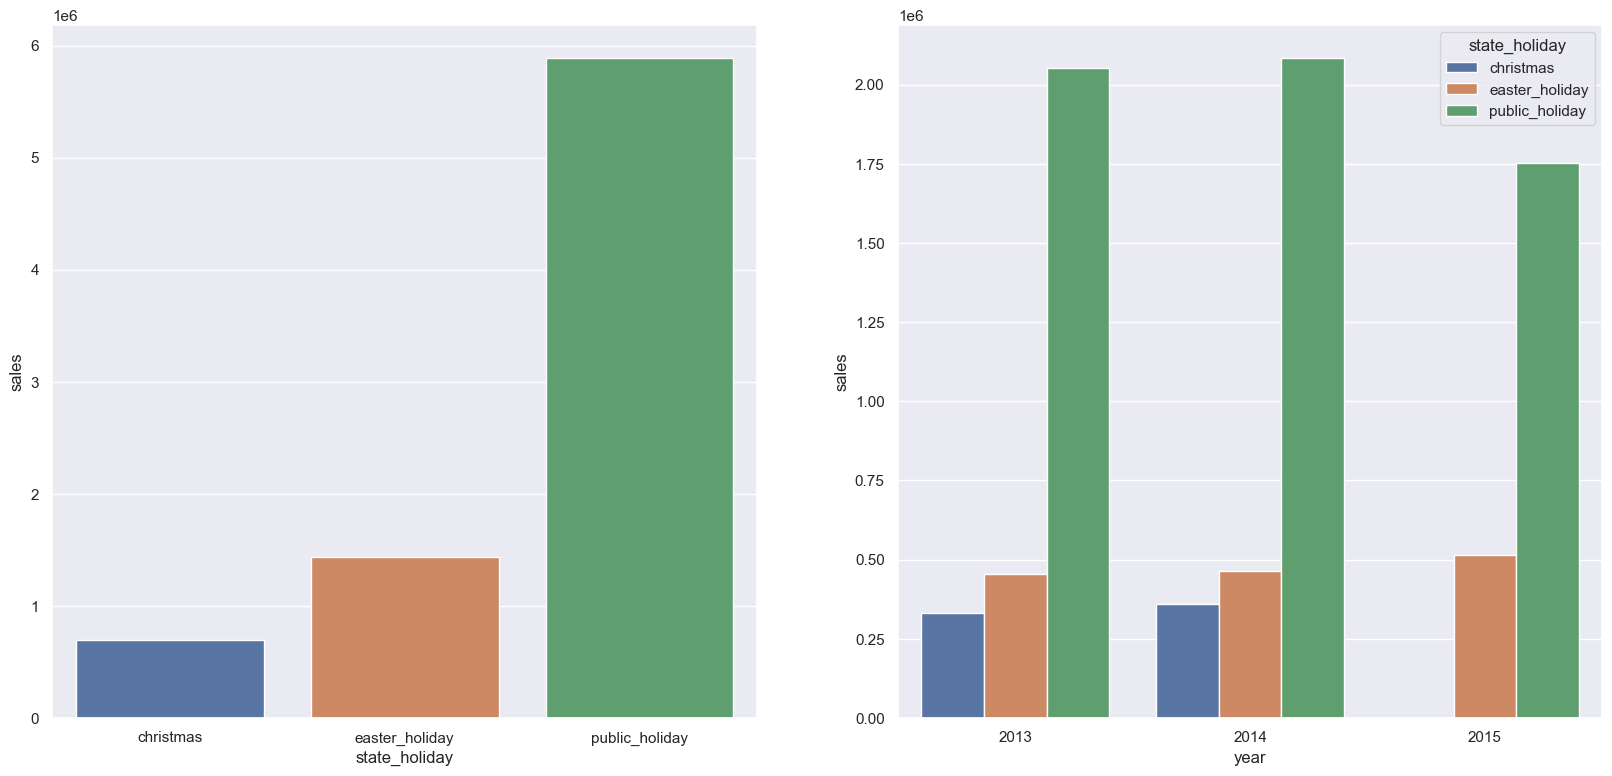

In [51]:
aux = df4[df4.state_holiday != 'regular_day']

plt.figure(figsize=(20,9))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales',data=aux1)

plt.subplot(1,2,2)
aux2 =aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday', data=aux2)

***Lojas abertas durante o feriado do natal não vendem mais***

##### **H8.** Lojas deveriam vender mais ao longo dos anos

<Axes: >

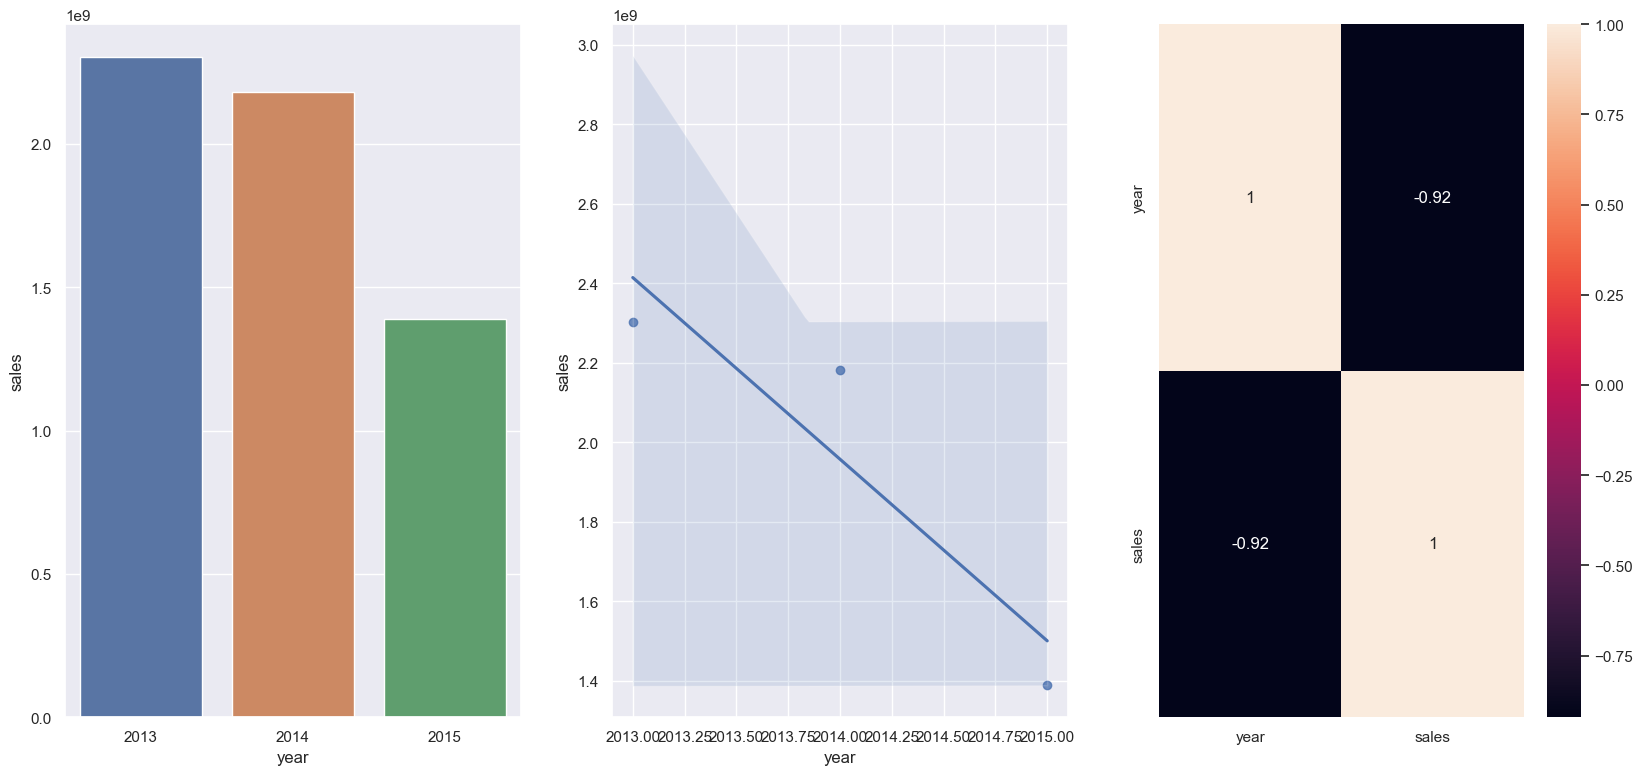

In [52]:
aux = df4[['year','sales']].groupby('year').sum().reset_index()


plt.figure(figsize=(20,9))
#Visualizando hipotese
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux)

# Visulizar a tendencia
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux)

#Correlação
plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)


***Lojas vendem menos ao longo dos anos***

##### **H9.** Lojas deveriam vender mais no segundo semestre do ano

<Axes: >

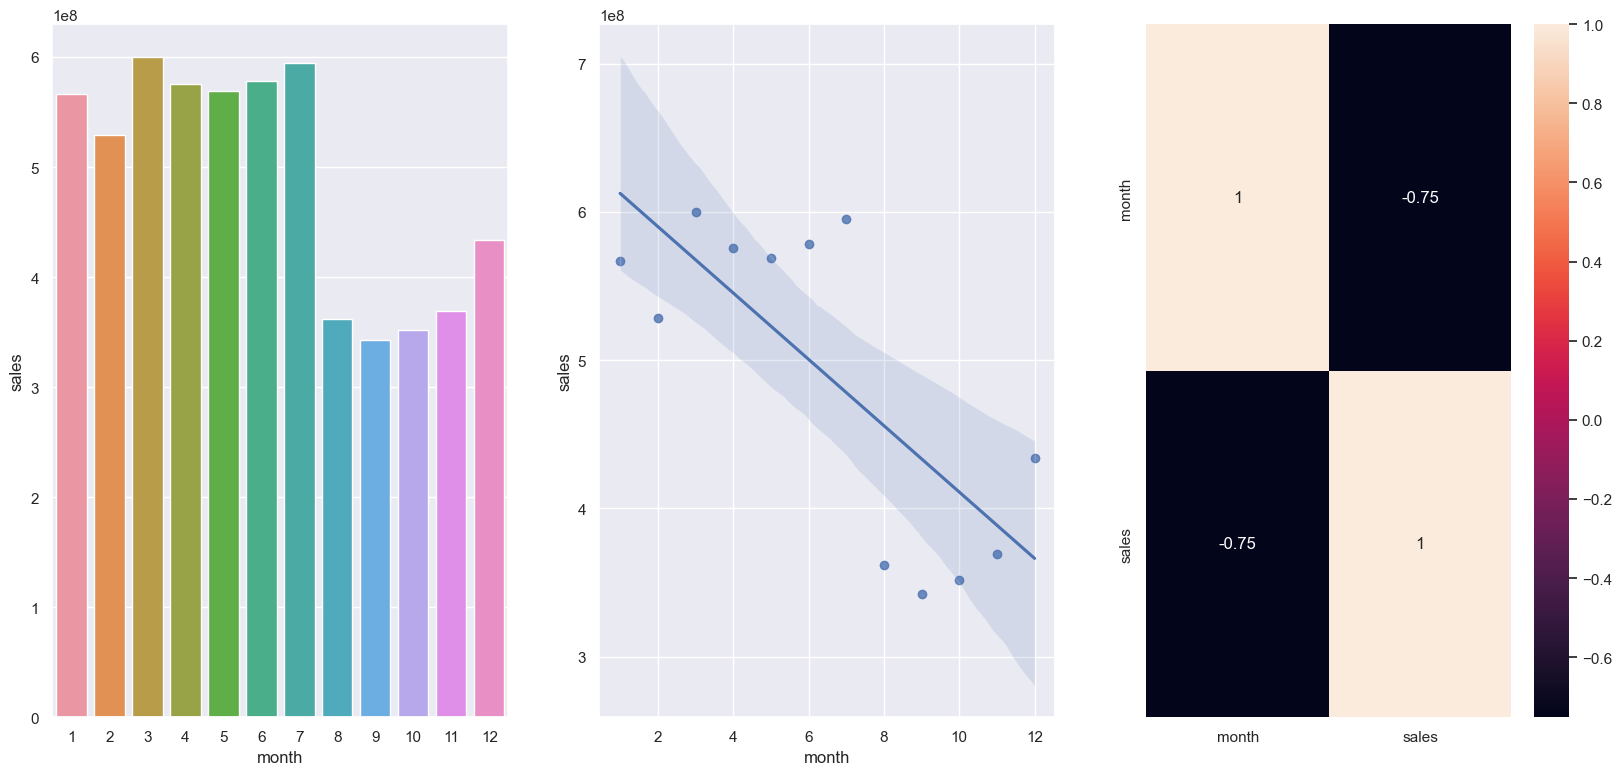

In [53]:
aux = df4[['month','sales']].groupby('month').sum().reset_index()


plt.figure(figsize=(20,9))
#Visualizando hipotese
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux)

# Visulizar a tendencia
plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux)

#Correlação
plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

***Lojas vendem menos no segundo semestre do ano***

##### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês

<Axes: xlabel='before_after', ylabel='sales'>

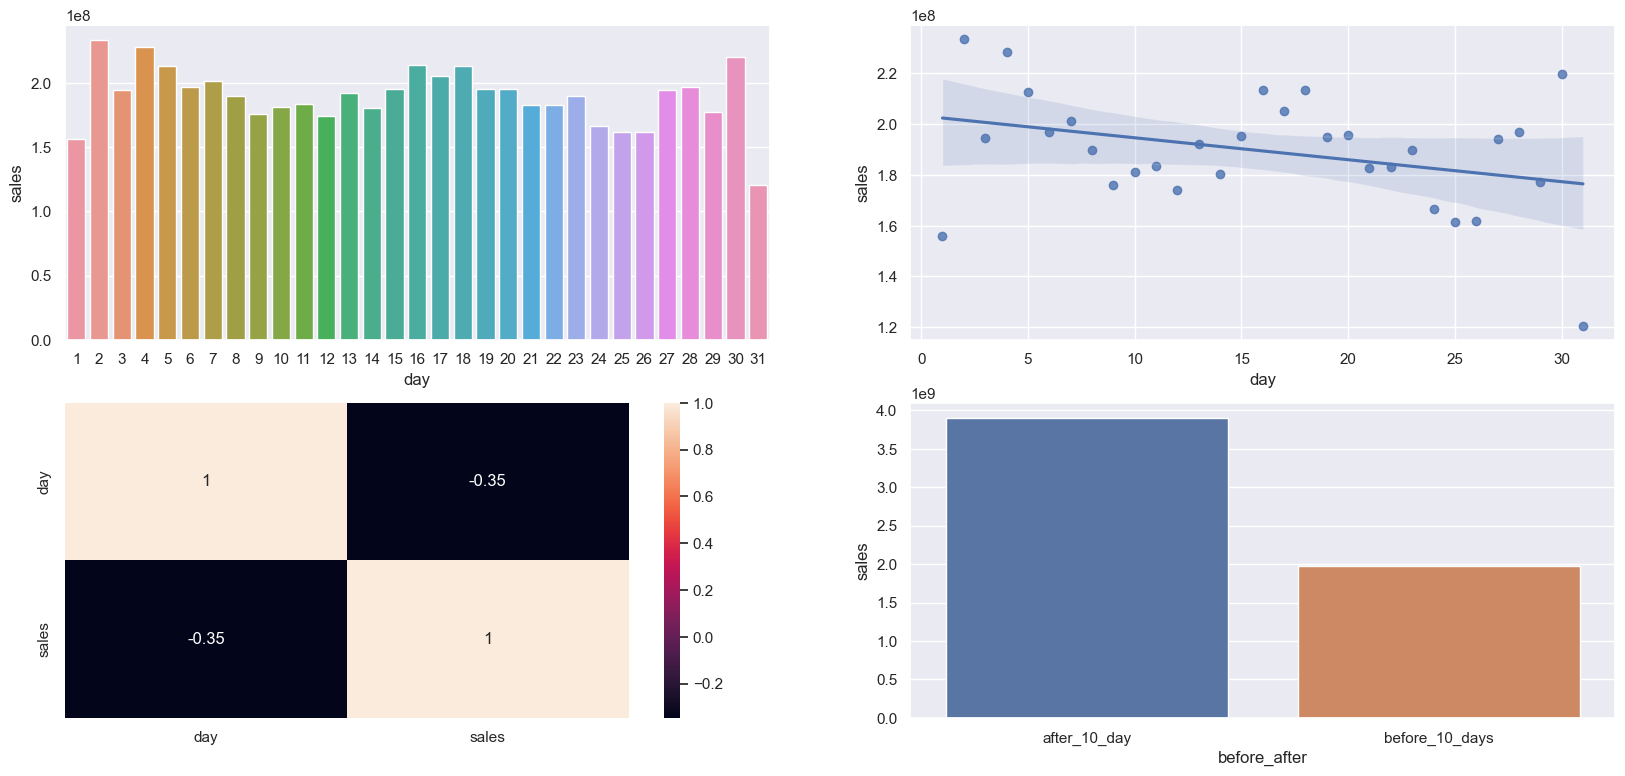

In [54]:
aux = df4[['day','sales']].groupby('day').sum().reset_index()


plt.figure(figsize=(20,9))
#Visualizando hipotese
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux)

# Visulizar a tendencia
plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux)

#Correlação
plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)

aux['before_after'] = aux.day.apply(lambda x:'before_10_days' if x <= 10 else 'after_10_day')


aux1 = aux[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux1)

***Lojas vendem mais depois do dia 10***

##### **H11.** Lojas deveriam vender menos aos finais de semana

<Axes: >

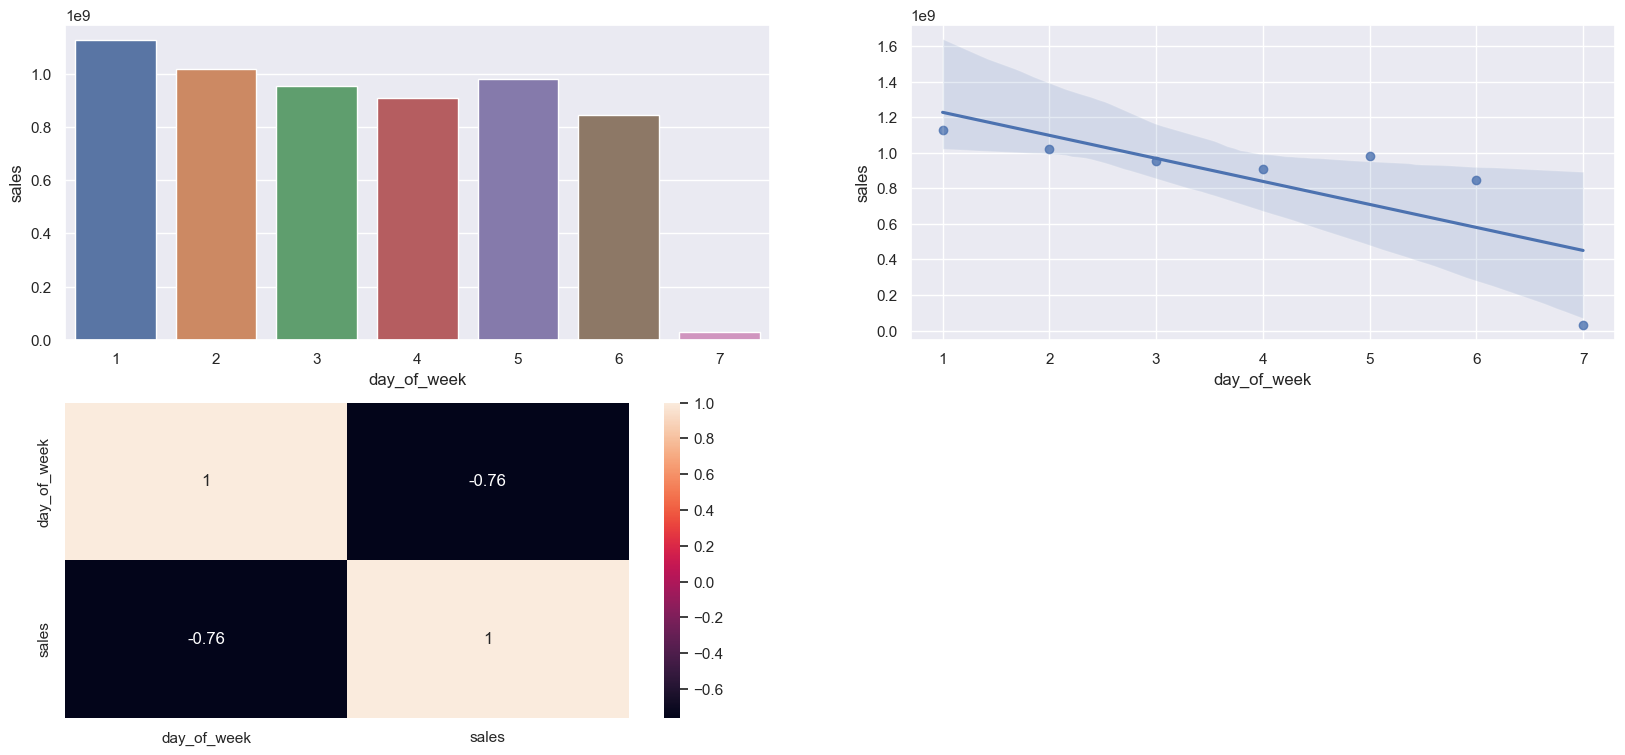

In [55]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()


plt.figure(figsize=(20,9))
#Visualizando hipotese
plt.subplot(2,2,1)
sns.barplot(x='day_of_week', y='sales', data=aux)

# Visulizar a tendencia
plt.subplot(2,2,2)
sns.regplot(x='day_of_week', y='sales', data=aux)

#Correlação
plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

***Lojas vendem menos no final de semana***

##### **H12.** Lojas deveriam vender menos durante os feriados escolares

<Axes: xlabel='month', ylabel='sales'>

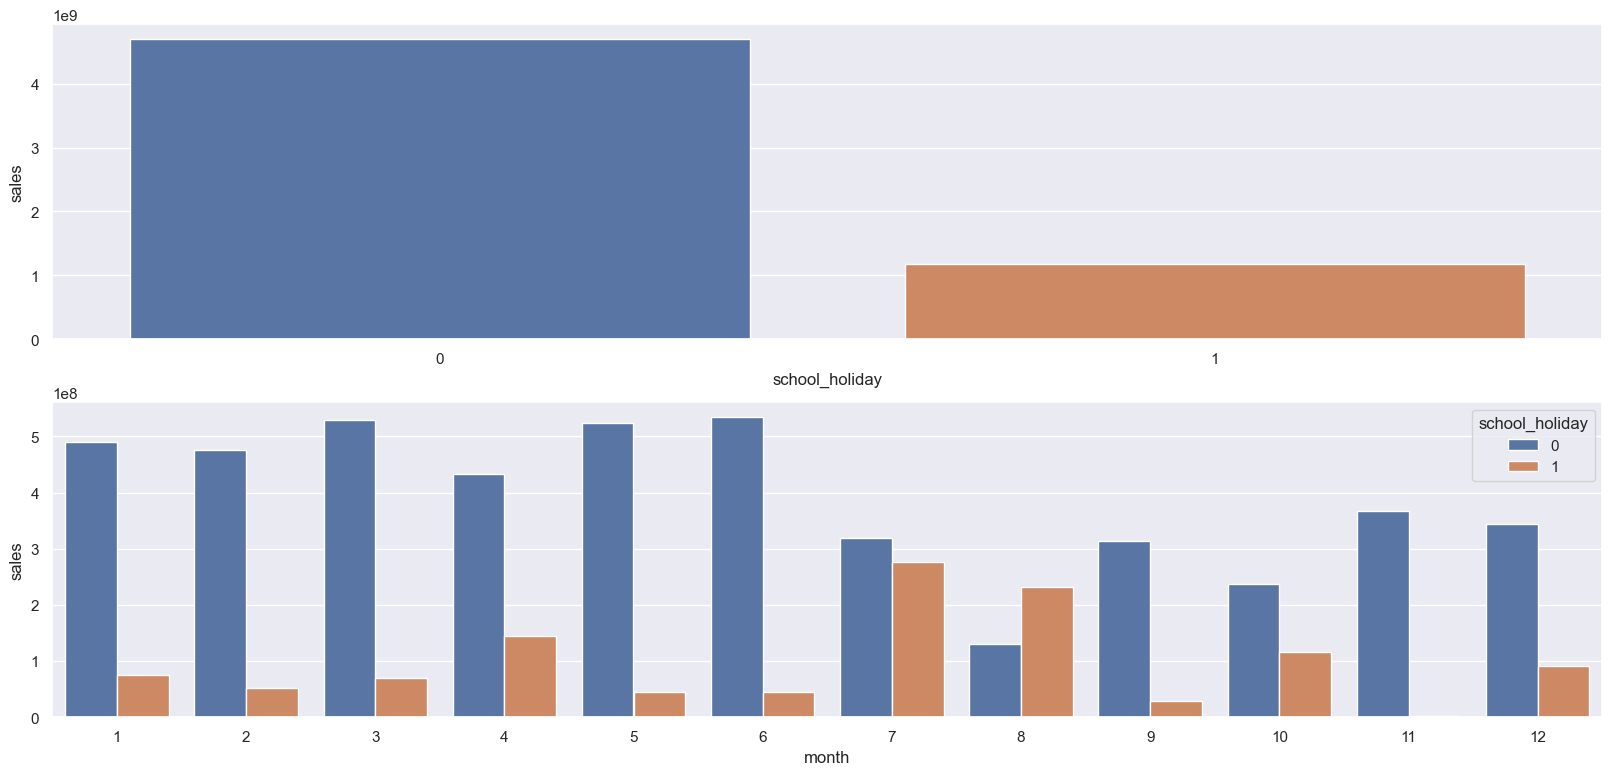

In [56]:
# Onde 0=Não tem feriado escolar e 1=Feriado escolar

plt.figure(figsize=(20,9))
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2)


#### 4.3. Analise Multivariada

##### 4.3.1 Atributos Numéricos

<Axes: >

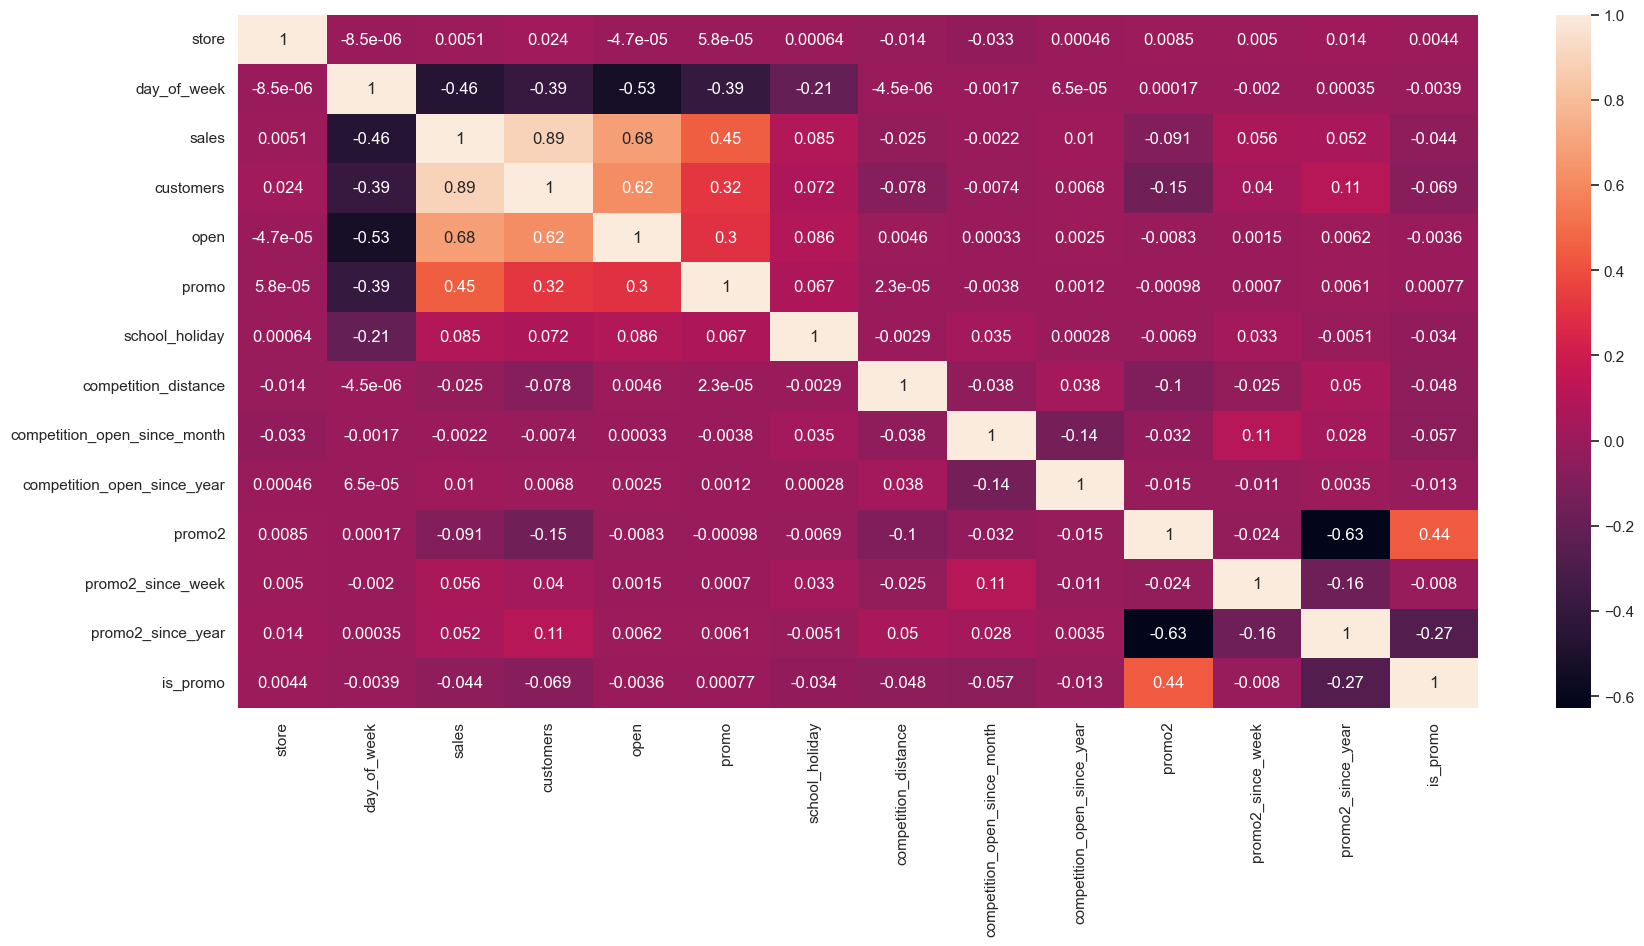

In [57]:
correlations = num_atributtes.corr(method='pearson')
plt.figure(figsize=(20,9))
sns.heatmap(correlations, annot=True)

##### 4.3.1 Atributos Categóricos

In [58]:
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


Text(0.5, 1.0, 'Heatmap: Correlação de Dados Categóricos (Cramer V)')

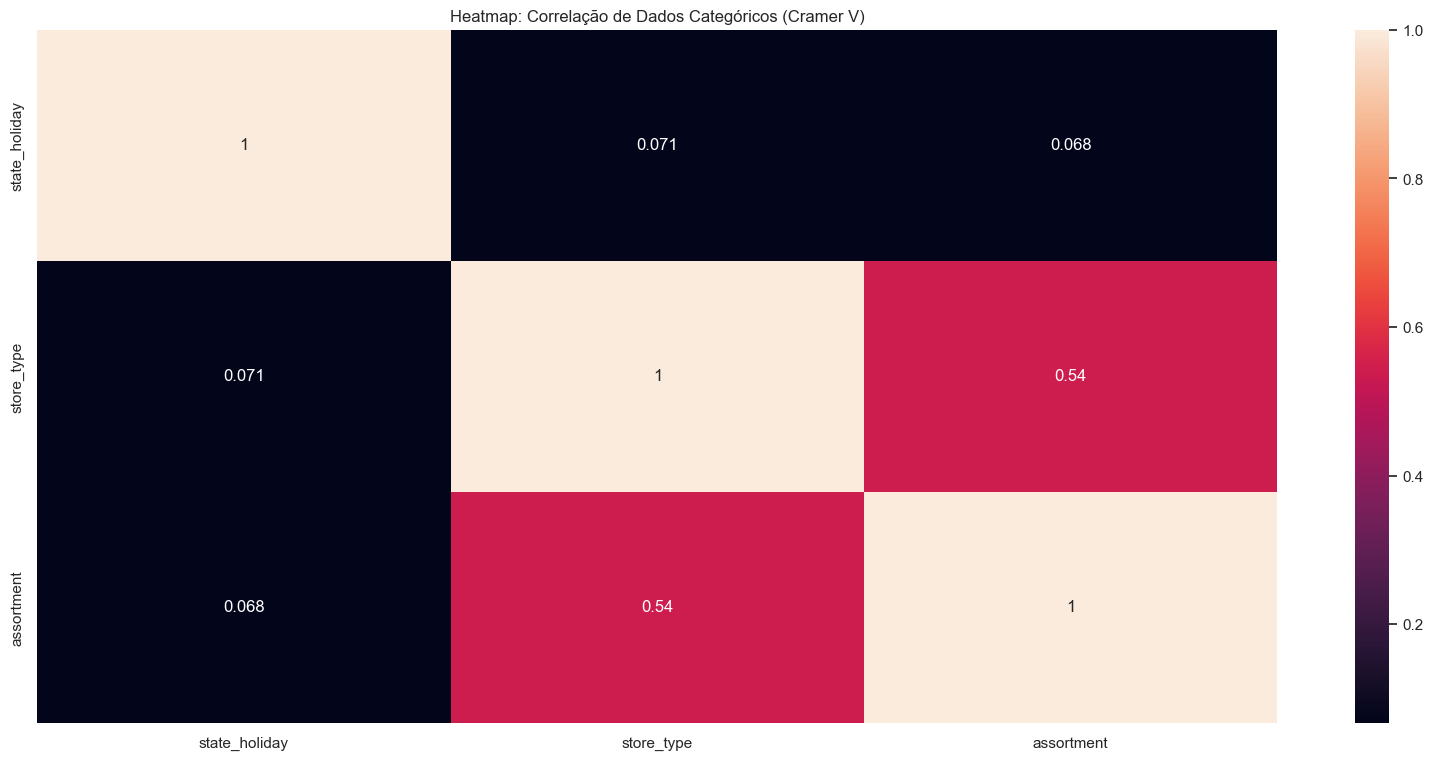

In [59]:
# Apenas dados categoricos
a = df4.select_dtypes(include='object')

# Calcular o V de Cramer
a1 = cramer_v(a.state_holiday, a.state_holiday)
a2 = cramer_v(a.state_holiday, a.store_type)
a3 = cramer_v(a.state_holiday, a.assortment)

a4 = cramer_v(a.store_type, a.state_holiday)
a5 = cramer_v(a.store_type, a.store_type)
a6 = cramer_v(a.store_type, a.assortment)

a7 = cramer_v(a.assortment, a.state_holiday)
a8 = cramer_v(a.assortment, a.store_type)
a9 = cramer_v(a.assortment, a.assortment)

# Dataset final
d = pd.DataFrame({'state_holiday':[a1,a2,a3],'store_type':[a4,a5,a6], 'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)

#Plot do heatmap de dados categoricos
plt.figure(figsize=(20,9))
sns.heatmap(d, annot=True)
plt.title('Heatmap: Correlação de Dados Categóricos (Cramer V)')

### 5.0 PREPARAÇÃO DOS DADOS

In [60]:
df5 = df4.copy()

#### 5.1. Normalização

Avaliar a distribuição das variáveis

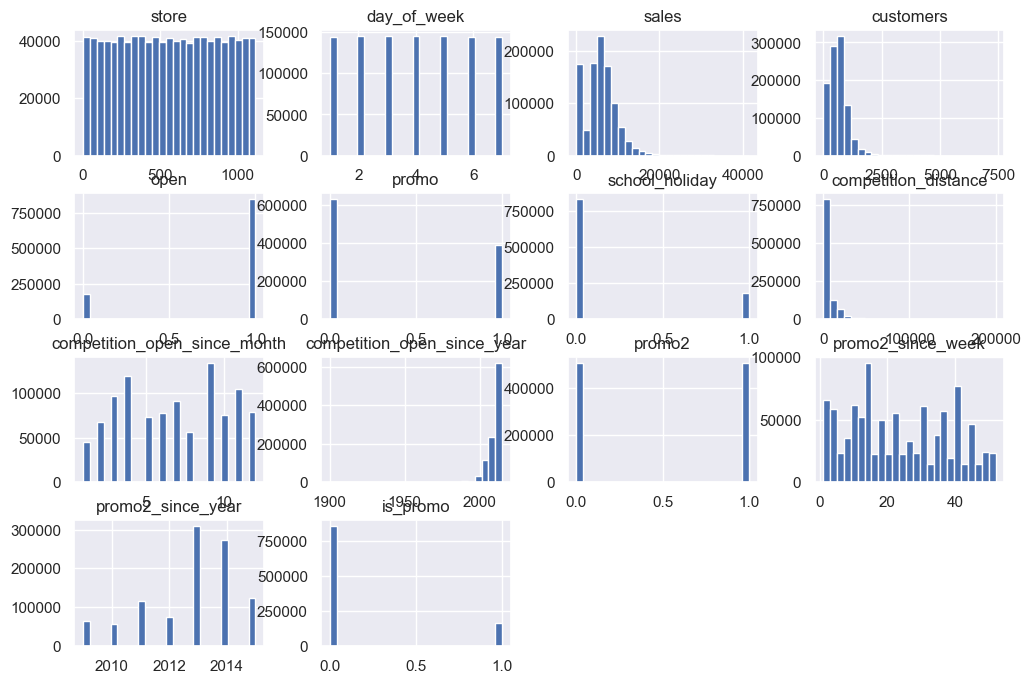

In [61]:
num_atributtes.hist(bins=25);

**Não tem nenhuma variavel com distribuição normal**

#### 5.2. Rescaling

In [66]:
# Filtrando os tipos de dados numericos 
a = df5.select_dtypes(include=['int64','int32','UInt32','float64'])

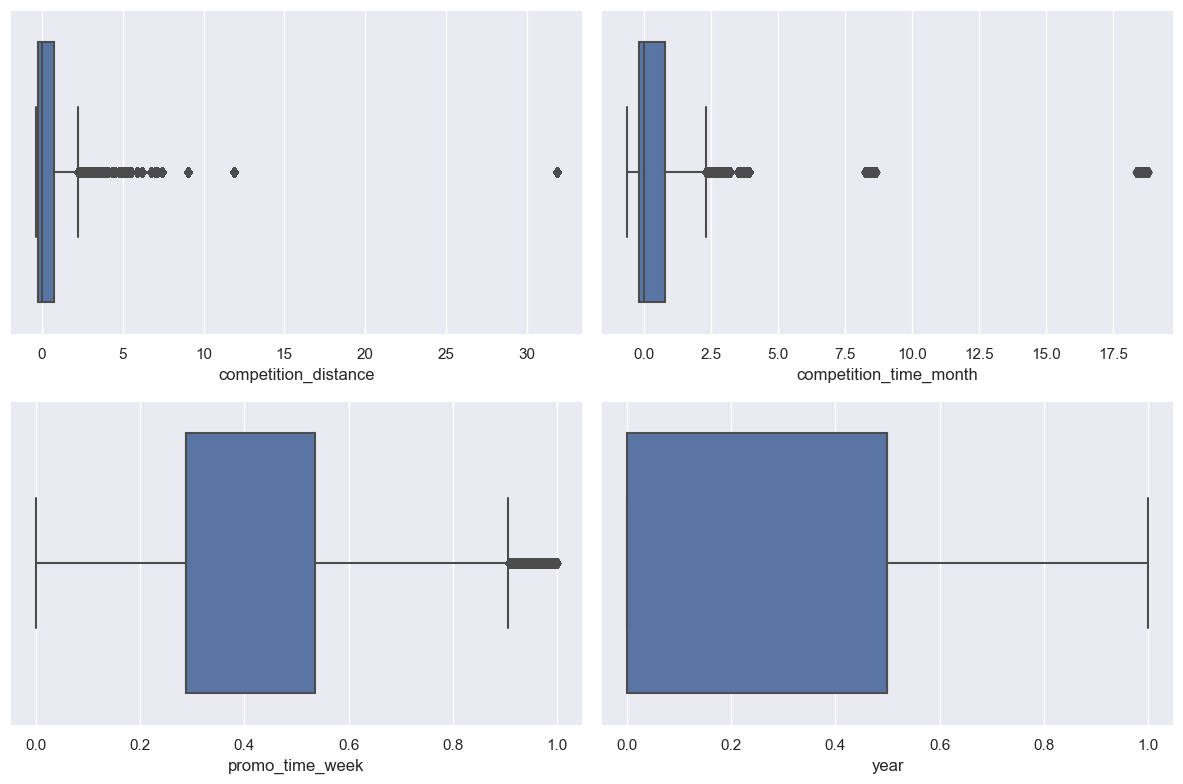

In [94]:
# Verificando os outliers das colunas 

fig, ax = plt.subplots(nrows=2, ncols=2)

# Plot do competition_distance
sns.boxplot(x=df5['competition_distance'], ax=ax[0, 0])
axes[0, 0].set_title('Competition Distance')

# Plot do competition_time_month
sns.boxplot(x=df5['competition_time_month'], ax=ax[0, 1])
axes[0, 1].set_title('Competition Time (Months)')

# Plot do promo_time_week
sns.boxplot(x=df5['promo_time_week'], ax=ax[1, 0])
axes[1, 0].set_title('Promo Time (Weeks)')

# Plot do year
sns.boxplot(x=df5['year'], ax=ax[1, 1])
axes[1, 1].set_title('Year')

# Ajuste do layout
plt.tight_layout()

plt.show()


In [87]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

#### 5.1. Transformação

In [96]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,0,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,0,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True


##### 5.1.1 Encoding

In [95]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

#assortment - Ordinal Enconding
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

##### 5.1.2 Transformação da Variavel Resposta

In [102]:
df5['sales'] = np.log1p(df5['sales'])

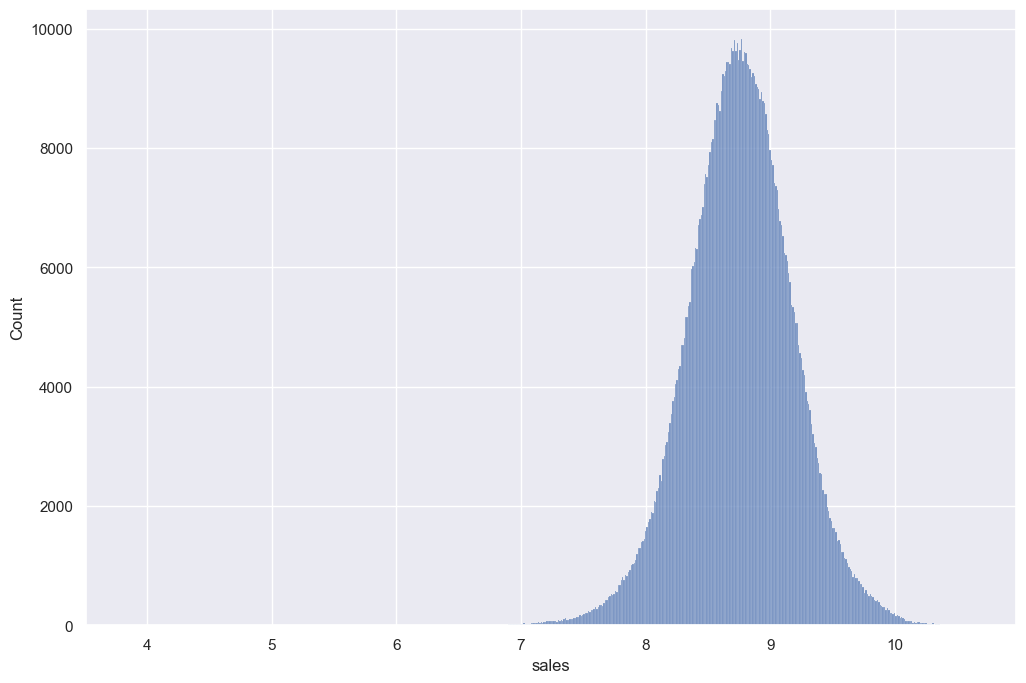

In [106]:
_ = sns.histplot(df5.sales)

##### 5.1.2 Transformação de Natureza Cíclica

In [107]:
# Natureza Ciclica

#month
df5['month_sin'] = df5.month.apply(lambda x:np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5.month.apply(lambda x:np.cos(x * (2 * np.pi/12)))

#day
df5['day_sin'] = df5.day.apply(lambda x:np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5.day.apply(lambda x:np.cos(x * (2 * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5.week_of_year.apply(lambda x:np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5.week_of_year.apply(lambda x:np.cos(x * (2 * np.pi/52)))

#day_of_week
df5['day_of_week_sin'] = df5.day_of_week.apply(lambda x:np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5.day_of_week.apply(lambda x:np.cos(x * (2 * np.pi/7)))

In [108]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,0,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,0,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
